# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os as os

## Funktionen definieren

In [2]:
def select_every_12th_with_start(arr, start_index):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 11")

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])
    
    return selected_elements

def linear_reg(x, m, t):
    return m*x + t

def generate_counting_array(length):
    return np.arange(length)

    
def selecting_month(arr, start_index, start_date, end_date):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 12")  # Change 11 to 12

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])

    tmp = xr.concat(selected_elements, dim="time")  # Concatenate the selected elements
    tmp = tmp.sel(time=slice(start_date, end_date))
    
    return tmp


def fit_count(arr):
    return generate_counting_array(len(arr))



def selecting_tf(arr,start_time, end_time):
    return arr.sel(time = slice(start_time, end_time))

def LinReg_All_Month(arr, time_start_displayed, time_start_fit, time_end, Name):
    # Create an empty DataFrame
    columns = ['month', 'slope', 'offset', 'var']
    parameters_df = pd.DataFrame(columns=columns)

    # Set 'month' as the index
    parameters_df.set_index('month', inplace=True)

    for month in range(1,13):
        # Select data
        y_data = selecting_month(arr,month, time_start_displayed, time_end)
        print(y_data)
        #Selecting fitting data
        y_temp = selecting_tf(y_data, time_start_fit, time_end)
        x_temp = fit_count(y_temp)

        #Fitting
        par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

        #Producing fitting output
        y_fit = linear_reg(x_temp, *par_LinReg)
        x_fit = y_temp['time'].values


        # #plt.plot(y_temp['time'].values, y_temp)
        # plt.plot(y_data['time'].values, y_data, marker = 'x', ls = '', label = 'data')
        # plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')

        #Calculating Varriance

        VarDeltaT = np.var(y_temp-y_fit)

        #Adding to df
        new_entry = {'slope': par_LinReg[0]*50, 'offset': par_LinReg[1], 'var': VarDeltaT.values}
        parameters_df.loc[str(month)] = new_entry


        # plt.xlabel('time')
        # plt.ylabel('DTR')

        # plt.title(Name + 'entire pol. reg. in month ' + str(month))

        # plt.xlim(time_values[800], time_values[-1])
        # plt.legend()
        # # Add a subtle background color
        # plt.gca().set_facecolor((0.95, 0.95, 0.95))

        # # Display the plot
        # plt.tight_layout()
        # plt.savefig(Ordner +'Bilder/LinReg/LinReg_'+Name+'_Month_'+ str(month)+'.png', dpi = 300)
        # plt.clf()
    return parameters_df

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

In [3]:
# print(DTR_Lat)
# selecting_month(DTR_Lat.dtr, 2, t_s_d, t_e)

### Gewichtung der Daten

In [4]:
def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

def TMax_selection(grad_min, grad_max):
    selected_data = TMax_Lat.sel(lat=slice(grad_min, grad_max)).tmx
    
    if np.isnan(selected_data).any():
        print('There is a Nan-Entry in your Max data selected!')
        return None
    else:
        weights = generate_cosine_weight(selected_data['lat'].values)
        result = np.dot(selected_data, weights)
        result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        return result_data_array

def TMin_selection(grad_min, grad_max):
    selected_data = TMin_Lat.sel(lat=slice(grad_min, grad_max))
    
    if np.isnan(selected_data.tmn).any():
        print('There is a Nan-Entry in your Min data selected!')
        return None
    else:
        weights = generate_cosine_weight(selected_data['lat'].values)
        result = np.dot(selected_data.tmn, weights)
        result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        return result_data_array

def temperature_diff_selection(grad_min, grad_max):
    tmax_result = TMax_selection(grad_min, grad_max)
    tmin_result = TMin_selection(grad_min, grad_max)
    
    if tmax_result is not None and tmin_result is not None:
        return tmax_result - tmin_result
    else:
        return None


## Speicherorte verwalten

## Daten importieren

In [5]:
# File paths
DTR_file = 'data\cru_ts4.07.1901.2022.dtr.dat.nc\cru_ts4.07.1901.2022.dtr.dat.nc'
TAvg_file = 'data\cru_ts4.07.1901.2022.tmp.dat.nc\cru_ts4.07.1901.2022.tmp.dat.nc'

# Load datasets
DTR = xr.open_dataset(DTR_file)
TAvg =  xr.open_dataset(TAvg_file)

## Differenz berechnen

In [6]:
#Projeziert auf eine latitude

DTR_Lat = DTR.mean('lon')
TAvg_Lat = TAvg.mean('lon')

In [27]:
print(np.sum(np.isnan(DTR_Lat.dtr)==False))



<xarray.DataArray 'dtr' ()>
array(409920)


ValueError: dimensions ('lat',) must have the same length as the number of data dimensions, ndim=0

In [7]:
time_values = DTR_Lat['time'].values

In [8]:
# TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
# TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
# TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')



In [9]:
# temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
# temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
# temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [10]:
# def weigth(arr):
#     return np.multiply(generate_cosine_weight(arr['lat'].values), arr)


# def temperature_diff_selection(grad_min, grad_max):
#    return TMax_selection(grad_min, grad_max) - TMin_selection(grad_min, grad_max)

# # def TMin_selection(grad_min, grad_max):
#     # return TMin_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmn
# # def TMin_selection(grad_min, grad_max):
# #     if np.isnan(TMin_Lat.sel(lat = slice(grad_min,grad_max)).tmn).any():
# #             print('There is a Nan-Entry in your Min data selected!')
# #     else:
# #         return np.dot(TMin_Lat.sel(lat = slice(grad_min,grad_max)).tmn, generate_cosine_weight(TMin_Lat.sel(lat = slice(grad_min,grad_max))['lat'].values))
# def TMin_selection(grad_min, grad_max):
#     selected_data = TMin_Lat.sel(lat=slice(grad_min, grad_max))
    
#     if np.isnan(selected_data.tmn).any():
#         print('There is a Nan-Entry in your Min data selected!')
#         return None  # Return None if there are NaN values
#     else:
#         weights = generate_cosine_weight(selected_data['lat'].values)
#         result = np.dot(selected_data.tmn, weights)
        
#         # Create a new xarray DataArray with the result and only 'time' dimension
#         result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        
#         return result_data_array


# # def TMax_selection(grad_min, grad_max):
# #     return TMax_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmx

# # def TMax_selection(grad_min, grad_max):
# #     if np.isnan(TMax_Lat.sel(lat = slice(grad_min,grad_max)).tmx).any():
# #         print('There is a Nan-Entry in your Max data selected!')
# #     else:
# #         return np.dot(TMax_Lat.sel(lat = slice(grad_min,grad_max)).tmx, generate_cosine_weight(TMax_Lat.sel(lat = slice(grad_min,grad_max))['lat'].values))

# def TMax_selection(grad_min, grad_max):
#     selected_data = TMax_Lat.sel(lat=slice(grad_min, grad_max)).tmx
    
#     if np.isnan(selected_data).any():
#         print('There is a Nan-Entry in your Max data selected!')
#         return None  # Return None if there are NaN values
#     else:
#         weights = generate_cosine_weight(selected_data['lat'].values)
#         result = np.dot(selected_data, weights)
#         # Create a new xarray DataArray with the result and only 'time' dimension
#         result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        
#         return result_data_array
# # print(np.linalg.norm(generate_cosine_weight(TMax_Lat.sel(lat = slice(60,80))['lat'].values)))
# # print(TMax_Lat.sel(lat = slice(60,80)).tmx)
# # print(TMax_Lat.sel(time = '1973-01-16T00:00:00.000000000',lat = slice(60,80)).mean('lat').tmx)
# # print(np.dot(TMax_Lat.sel(lat = slice(60,80)).tmx, generate_cosine_weight(TMax_Lat.sel(lat = slice(60,80))['lat'].values)))
# # print(TMax_selection(60,87))
# # print(np.isnan(TMax_Lat.sel(lat = slice(60,87)).tmx).any())
# # # print(np.isnan(TMax_Lat.sel(lat = slice(60,80)).tmx).any())
# # print(TMin_selection(60,86))
# #print(temperature_diff_selection(60,70))
# print(TMax_selection(60,70))
# print(type(TMax_selection(60,70)))

In [11]:
def weight(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

def selection(arr, lon_min, lon_max):
    return arr.sel(lat = slice(lon_min, lon_max))

# def TMax_selection(grad_min, grad_max):
#     selected_data = TMax_Lat.sel(lat=slice(grad_min, grad_max)).tmx
    
#     if np.isnan(selected_data).any():
#         print('There is a Nan-Entry in your Max data selected!')
#         return None
#     else:
#         weights = generate_cosine_weight(selected_data['lat'].values)
#         result = np.dot(selected_data, weights)
#         result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
#         return result_data_array

# def TMin_selection(grad_min, grad_max):
#     selected_data = TMin_Lat.sel(lat=slice(grad_min, grad_max))
    
#     if np.isnan(selected_data.tmn).any():
#         print('There is a Nan-Entry in your Min data selected!')
#         return None
#     else:
#         weights = generate_cosine_weight(selected_data['lat'].values)
#         result = np.dot(selected_data.tmn, weights)
#         result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
#         return result_data_array

# def temperature_diff_selection(grad_min, grad_max):
#     tmax_result = TMax_selection(grad_min, grad_max)
#     tmin_result = TMin_selection(grad_min, grad_max)
    
#     if tmax_result is not None and tmin_result is not None:
#         return tmax_result - tmin_result
#     else:
#         return None


## Plots

In [12]:

name_region = 'NordPol2'

if not os.path.exists(name_region):
    os.mkdir(name_region)
# Zu betrachtender Bereich 
    #Zeit
t_s_d = '1901-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]

    #Ort
lon_min = 60
lon_max = 61

name_breitengrad = 'Lon_'+str(lon_min)+'_'+str(lon_max)+'/'
if not os.path.exists(name_region+name_breitengrad):
    os.mkdir(name_region+name_breitengrad)


### Loops Fit

In [13]:
name_Ordner_Fit = 'Fit/'
if not os.path.exists(name_region + name_breitengrad + name_Ordner_Fit):
    os.mkdir(name_region + name_breitengrad + name_Ordner_Fit)

In [14]:
# temperature_diff_selection(60,80)
print(np.sum(False == np.isnan(selection(weight(DTR_Lat.dtr), lon_min, lon_max))))
print(selection(weight(DTR_Lat.dtr), lon_min,lon_max))
#parameters_DTR = LinReg_All_Month(selection(weight(DTR_Lat.dtr), lon_min, lon_max), t_s_d, t_s_f, t_e, 'DTR')
# parameters_TMax = LinReg_All_Month(TMax_selection(lon_min,lon_max), t_s_d, t_s_f, t_e, 'TMax')
# parameters_TMin = LinReg_All_Month(TMin_selection(lon_min,lon_max), t_s_d, t_s_f, t_e, 'TMin')

<xarray.DataArray 'dtr' ()>
array(2928)
<xarray.DataArray 'dtr' (time: 1464, lat: 2)>
array([[0.01765699, 0.01755224],
       [0.02136469, 0.02117452],
       [0.02513028, 0.02514575],
       ...,
       [0.01411366, 0.01378569],
       [0.01385914, 0.01389548],
       [0.01546975, 0.01543853]], dtype=float32)
Coordinates:
  * lat      (lat) float32 60.25 60.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2022-12-16


### Plots Fitting

In [15]:
# # Create the plot
# plt.errorbar(parameters_TDiff['slope'], parameters_TDiff.index, xerr=parameters_TDiff['var'], fmt='x', capsize= 3,ecolor= 'black', elinewidth=1, label='slope with error')
# plt.xlabel('Slope')
# plt.ylabel('Month')
# plt.title('Slope vs Month with Error Bars')
# plt.legend()
# plt.grid(True)
# plt.show()

In [16]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TDiff['slope'], parameters_TDiff.index, color = 'r',
    xerr=parameters_TDiff['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='DTR'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('DTR vs Month: '+ name_breitengrad)

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.xlim(-0.65, 0.25)
plt.tight_layout()  # Adjust spacing
plt.savefig(name_region + name_breitengrad + name_Ordner_Fit + 'DTRperMonth.png', dpi = 300)
plt.show()

NameError: name 'parameters_TDiff' is not defined

<Figure size 720x432 with 0 Axes>

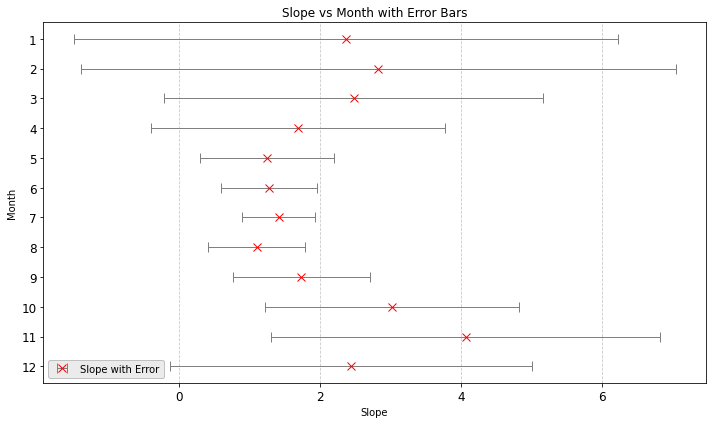

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'r',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

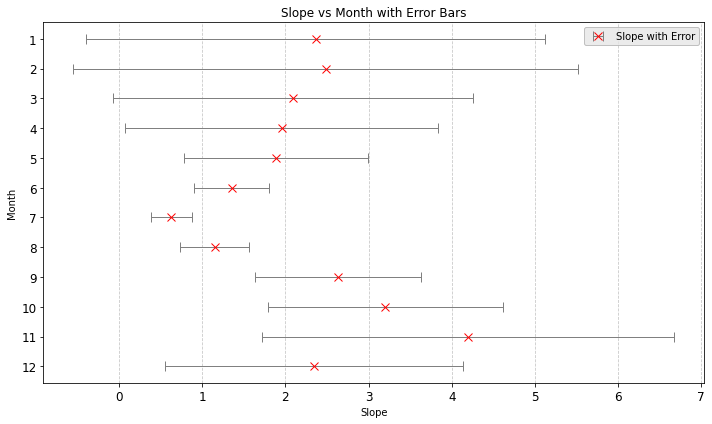

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

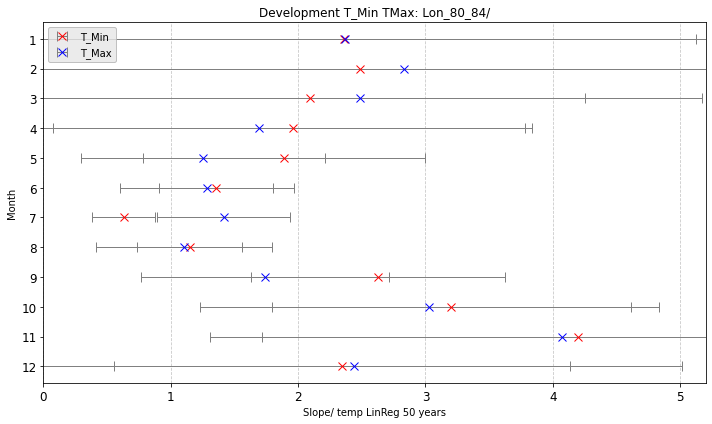

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'b',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='b', markeredgewidth=1, label='T_Max'
)

plt.xlabel('Slope/ temp LinReg 50 years')
plt.ylabel('Month')
plt.title('Development T_Min TMax: '+ name_breitengrad)

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.xlim(0, 5.2)

plt.tight_layout()  # Adjust spacing
plt.savefig(name_region + name_breitengrad + name_Ordner_Fit + 'T_Min_T_Max.png', dpi = 300)
plt.show()

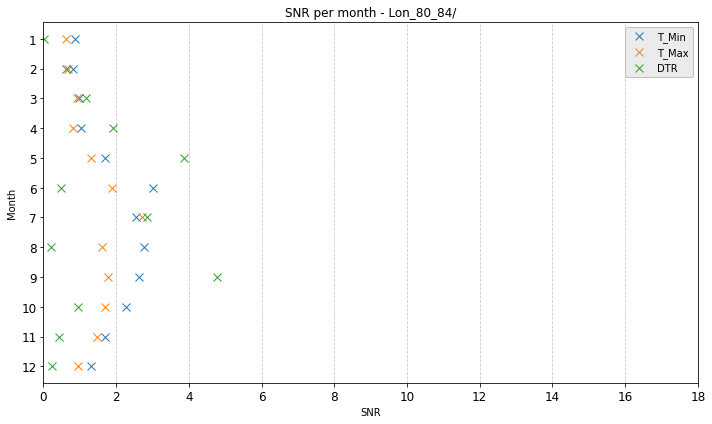

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['SNR'], parameters_TMin.index,
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['SNR'], parameters_TMax.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Max'
)

plt.errorbar(
    parameters_TDiff['SNR'], parameters_TDiff.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='DTR'
)


plt.xlabel('SNR')
plt.ylabel('Month')
plt.title('SNR per month - '+name_breitengrad)

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.xlim(0, 18)

plt.tight_layout()  # Adjust spacing
plt.savefig(name_region + name_breitengrad + name_Ordner_Fit + 'SNR.png',dpi = 300)
plt.show()

## Scatter plots

### Definitionen und Setup

In [ ]:
name_ordner_scatter = 'ScatterPlot/'
if not os.path.exists(name_region + name_breitengrad + name_ordner_scatter):
    os.mkdir(name_region + name_breitengrad + name_ordner_scatter)

In [ ]:
#Graphischen Layout
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown', 'olive', 'gray']
month_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

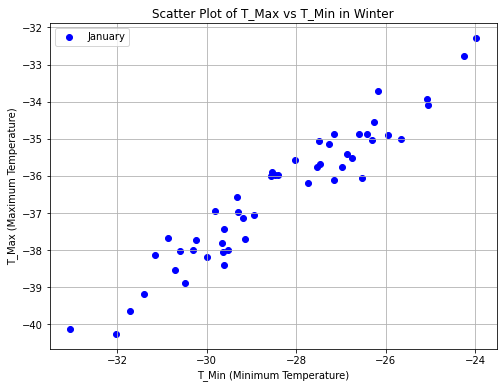

In [ ]:
month = 1
arr1 = TMax_selection(lon_min,lon_max)
arr2 = TMin_selection(lon_min,lon_max)
month = 1
# Select data
y_data1 = selecting_month(arr1,month, t_s_f, t_e)
y_data2 = selecting_month(arr2,month, t_s_f, t_e)
#Selecting fitting data

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_data1, y_data2, color='blue', label= month_label[month-1])
plt.title('Scatter Plot of T_Max vs T_Min in Winter')
plt.xlabel('T_Min (Minimum Temperature)')
plt.ylabel('T_Max (Maximum Temperature)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
# month_label = ['January', 'February', 'March',...]

# plt.figure(figsize=(10, 8))

# for month in range(1, 13):
#     arr1 = TMax_selection(lon_min, lon_max)
#     arr2 = TMin_selection(lon_min, lon_max)

#     y_data1 = selecting_month(arr1, month, t_s_f, t_e)
#     y_data2 = selecting_month(arr2, month, t_s_f, t_e)

#     plt.scatter(y_data1, y_data2, color=colors[month - 1], label=f'Month {month_label}')

# plt.title('Scatter Plot of T_Max vs T_Min for All Months')
# plt.xlabel('T_Min (Minimum Temperature)')
# plt.ylabel('T_Max (Maximum Temperature)')
# plt.legend()
# plt.grid(True)
# plt.show()

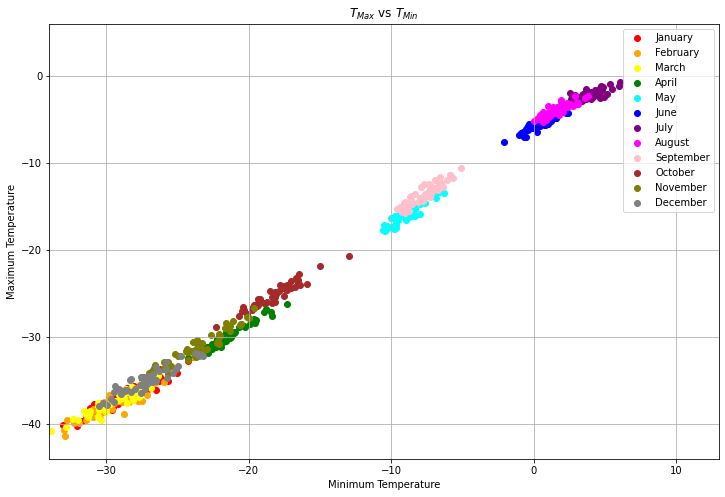

In [ ]:


plt.figure(figsize=(12, 8))

for month in range(1, 13):
    arr1 = TMax_selection(lon_min, lon_max)
    arr2 = TMin_selection(lon_min, lon_max)

    y_data1 = selecting_month(arr1, month, t_s_f, t_e)
    y_data2 = selecting_month(arr2, month, t_s_f, t_e)

    plt.scatter(y_data1, y_data2, color=colors[month - 1], label=month_label[month - 1])

plt.xlim(-34, 13)
plt.ylim(-44, 6)

plt.title('$T_{Max}$ vs $T_{Min}$')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.grid(True)
plt.savefig(name_region + name_breitengrad + name_ordner_scatter +'ScatterTMinTMax.png',dpi =300)
plt.show()

In [ ]:
# %matplotlib inline
# month = 4
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# print(y_data1['time'].values)

# arr1 = TMax_selection(lon_min, lon_max)
# arr2 = TMin_selection(lon_min, lon_max)
# y_data1 = selecting_month(arr1, month, t_s_d, t_e)
# y_data2 = selecting_month(arr2, month, t_s_d, t_e)
# ax.scatter(y_data1, y_data2,1900*np.ones(len(y_data1))+range(len(y_data1)), color=colors[month - 1], label=month_label[month - 1])

# plt.title('Scatter Plot of T_Max vs T_Min for All Months')
# plt.xlabel('T_Min (Minimum Temperature)')
# plt.ylabel('T_Max (Maximum Temperature)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation


# colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
# month_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# month = 4
# fig = plt.figure(figsize=(10, 8))
# plt.title(f'Scatter Plot of T_Max vs T_Min for {month_label[month - 1]}')
# plt.xlabel('T_Min (Minimum Temperature)')
# plt.ylabel('T_Max (Maximum Temperature)')
# plt.grid(True)

# arr1 = TMax_selection(lon_min, lon_max)
# arr2 = TMin_selection(lon_min, lon_max)
# y_data1 = selecting_month(arr1, month, t_s_d, t_e)
# y_data2 = selecting_month(arr2, month, t_s_d, t_e)
# scatter = plt.scatter([], [], color=colors[month - 1], label=month_label[month - 1])

# def init():
#     return scatter,

# def animate(i):
#     if i < len(y_data1):
#         scatter.set_offsets(np.c_[y_data1[:i+1], y_data2[:i+1]])
#     return scatter,

# ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(y_data1), interval=1, blit=True)
# plt.legend()

# ani.save('test.gif')


In [ ]:
# # Your import statements here

# # Define your functions and variables here

# colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
# month_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# month = 4
# fig = plt.figure(figsize=(10, 8))
# plt.title(f'Scatter Plot of T_Max vs T_Min for {month_label[month - 1]}')
# plt.xlabel('T_Min (Minimum Temperature)')
# plt.ylabel('T_Max (Maximum Temperature)')
# plt.grid(True)

# # Define your data arrays here

# scatter = plt.scatter([], [], color=colors[month - 1], label=month_label[month - 1])

# def init():
#     return scatter,

# def animate(i):
#     if i < len(y_data1):
#         scatter.set_offsets(np.c_[x_data[:i+1], y_data[:i+1]])  # Update x_data and y_data accordingly
#     return scatter,

# ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(y_data1), interval=2, blit=True)  # Adjust interval as needed

# plt.legend()

# ani.save('test.gif', writer='imagemagick')  # Use 'imagemagick' writer for better compatibility
# plt.close()  # Close the animation to prevent memory leaks


### Hearmap

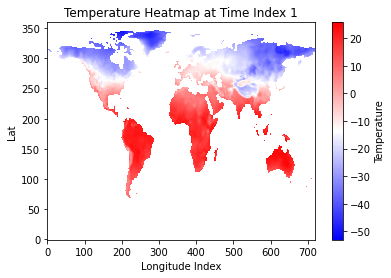

In [ ]:
time_index = 1
temperature_data = TMin.isel(time=time_index).tmn#,lon = range(0,260), lat = range(330,360)).tmn

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title(f'Temperature Heatmap at Time Index {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Lat')
plt.show()